<a href="https://colab.research.google.com/github/oneoftwo/generative_model_tutorials/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adverserial Network**

## **Import and Download Dataset**

In [8]:
import numpy as np
import random as random
import time as time
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F


from matplotlib import pyplot as plt
from matplotlib import cm

In [9]:
#==============================================================================#
# excecute ====================================================================#
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision import datasets, transforms
batch_size = 16
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
    train=True, download=True)
test_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
    train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, \
    shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, \
    shuffle=True, drop_last=True)
#==============================================================================#

## **Utils**

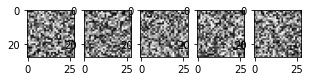

In [10]:
################################################################################
# utils ########################################################################
def plot_10(x):
        fig = plt.figure(figsize=(10, 30))
        for idx in range(5):
            img = x[idx].cpu().squeeze().detach().numpy()
            ax = fig.add_subplot(1, 10, idx + 1)
            ax.imshow(img, cmap=cm.gray)
        plt.show()
plot_10(torch.rand(20, 1, 28, 28))

## **Model**
Generative adverserial network

In [11]:
################################################################################
# GAN ##########################################################################

def sampler(batch_size, z_dim):
    z = torch.randn(batch_size, z_dim)
    return z

# GAN generator
class Generator(nn.Module):
    
    def __init__(self, z_dim=2):
        super().__init__()
        self.fc = nn.Sequential(\
                nn.Linear(z_dim, 128), \
                nn.SiLU(), \
                nn.Linear(128, 256), \
                nn.SiLU(), \
                nn.Linear(256, 512), \
                nn.SiLU(), \
                nn.Linear(512, 28 * 28))
        
    def forward(self, z):
        b = z.size(0)
        x = self.fc(z)
        x = x.view(b, 1, 28, 28)
        x = torch.sigmoid(x)
        return x


# GAN discriminaotr, CNN based classifier
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(\
                nn.Linear(28 * 28, 128), \
                nn.ReLU(), \
                nn.Linear(128, 64), \
                nn.ReLU(), \
                nn.Linear(64, 1))
        
    def forward(self, x):
        b = x.size(0)
        x = x.reshape(b, -1)
        x = self.fc(x)
        x = torch.sigmoid(x).squeeze()
        return x

################################################################################


#==============================================================================#
# excecute ====================================================================#
g = Generator()
d = Discriminator()
z = sampler(32, 2)
print(z.size())
print(g(z).size())
print(d(g(z)).size())
#==============================================================================#


torch.Size([32, 2])
torch.Size([32, 1, 28, 28])
torch.Size([32])


## **Train**

100%|██████████| 3750/3750 [00:32<00:00, 115.03it/s]


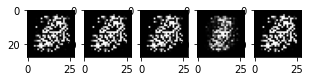

26129.49922001362 632.5258923965168


100%|██████████| 3750/3750 [00:32<00:00, 114.78it/s]


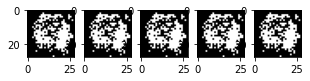

16214.059971392155 907.8794119171671


100%|██████████| 3750/3750 [00:32<00:00, 114.94it/s]


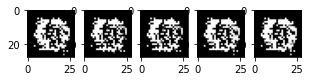

22799.549812555313 585.2624325518622


100%|██████████| 3750/3750 [00:32<00:00, 114.75it/s]


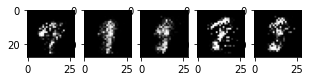

15452.003538489342 1199.798216211926


100%|██████████| 3750/3750 [00:32<00:00, 114.90it/s]


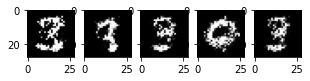

9346.582692623138 2277.739695366472


100%|██████████| 3750/3750 [00:32<00:00, 114.48it/s]


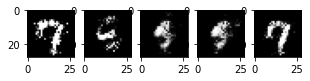

6720.879117906094 2859.809965953231


100%|██████████| 3750/3750 [00:32<00:00, 114.88it/s]


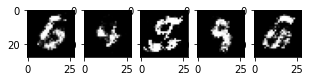

5289.8723576664925 3354.406898021698


100%|██████████| 3750/3750 [00:32<00:00, 114.22it/s]


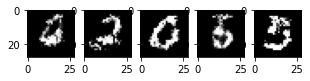

5082.777698278427 3476.623535901308


100%|██████████| 3750/3750 [00:32<00:00, 114.31it/s]


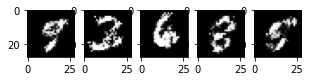

4736.646146833897 3584.646919697523


 29%|██▉       | 1079/3750 [00:09<00:23, 111.74it/s]

In [ ]:
################################################################################
# train fxn ####################################################################

def train_gan_single_epoch(generator, discriminator, train_loader):
    generator.cuda()
    discriminator.cuda()
    g_optimizer = optim.Adam(generator.parameters(), lr=3e-4)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4)
    criterion = nn.BCELoss()
    epoch_loss_d, epoch_loss_g = 0, 0
    # update parameters
    for img, label in tqdm(train_loader):
        img, label = img.cuda(), label.cuda()
        b = img.size(0)
        # update discriminator
        d_optimizer.zero_grad()
        prob_real = discriminator(img)
        prob_fake = discriminator(generator(sampler(b, 32).cuda()))
        loss_real = criterion(prob_real, torch.ones(prob_real.size()).cuda())
        loss_fake = criterion(prob_fake, torch.zeros(prob_fake.size()).cuda())
        loss_d = (loss_real + loss_fake)
        loss_d.backward()
        d_optimizer.step()
        epoch_loss_d += loss_d.item()
        # update generator
        g_optimizer.zero_grad()
        prob_fake = discriminator(generator(sampler(b, 32).cuda()))
        loss_g = criterion(prob_fake, torch.ones(prob_fake.size()).cuda())
        loss_g.backward()
        g_optimizer.step()
        epoch_loss_g += loss_g.item()
    plot_10(generator(sampler(b, 32).cuda()))
    return generator, discriminator, epoch_loss_g, epoch_loss_d

################################################################################


#==============================================================================#
# excecute ====================================================================#
g = Generator(z_dim=32)
d = Discriminator()
for epoch_idx in range(200):
    g, d, epoch_loss_g, epoch_loss_d = \
            train_gan_single_epoch(g, d, train_loader)
    print(epoch_loss_g, epoch_loss_d)
#==============================================================================#


## **Plot Generated Images**

In [ ]:
1